# Compare Madrasin to Control

## Purpose

In this script we are going to get the ratios of whole genomic reads to transcriptome reads for all the different experimental conditions to see which condition is ideal for getting the most intronic reads

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [3]:
# Set variable to remove non-coding genes
removeNC=True
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [4]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    print geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)
              0               1
0       DDX11L1     NR_046018.2
1        WASH7P     NR_024540.1
2   MIR1302-2HG  XR_001737835.1
3       FAM138A     NR_026818.1
4  LOC100996442  XR_001737582.2


In [5]:
if feature=="Gene":
    fileToRead="quant.genes.sf"
else:
    fileToRead="quant.sf"

In [6]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=100

In [8]:
# Get highly expressed features from each file for the Madrasin data
top_features_Madrasin = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if "Mad" in filename and "transcripts_quant_genenames" in filename and "transcripts_quant_genenames_" not in filename and (("DMS" in filename and "Mad-30mm-8hr-DMS" not in filename) or ("Mad-30mm-8hr-minus_S12" in filename)):
        print filename
        # Read the salmon output file
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Sort the data by TPM
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first 100 features
        if numFeatures==0:
            top_features_Madrasin.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Madrasin.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

Mad-30mm-8hr-minus_S12_transcripts_quant_genenames
Mad-20mm-8hr-DMS_S8_transcripts_quant_genenames
Mad-10mm-8hr-DMS_S7_transcripts_quant_genenames
Mad-20mm-4hr-DMS_S2_transcripts_quant_genenames
Mad-10mm-4hr-DMS_S1_transcripts_quant_genenames
Mad-30mm-4hr-DMS_S3_transcripts_quant_genenames


In [9]:
# Get highly expressed features from each file for control data
top_features_Control = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if "All" in filename and "transcripts_quant_genenames" in filename:
        print filename
        # Read the salmon output file
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Sort the data by TPM
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first 100 features
        if numFeatures==0:
            top_features_Control.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Control.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

All_Minusfiles_transcripts_quant_genenames
All_DMSfiles_transcripts_quant_genenames


In [22]:
# Combine the two feature files together to get a unique list
#unique_top_features = list(set(top_features_Madrasin + top_features_Control))
unique_top_features = list(set(top_features_Madrasin))
print(len(unique_top_features))

131


In [23]:
# Create a data frame with unique top features as column
feature_readCounts_Madrasin = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_Madrasin.columns.values)
    if "Mad" in filename and "transcripts_quant_genenames" in filename and "transcripts_quant_genenames_" not in filename:
        print filename
        current_columns.append(filename.split("_transcripts")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_Madrasin = pd.concat([feature_readCounts_Madrasin,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_Madrasin.columns = current_columns

Mad-30mm-8hr-minus_S12_transcripts_quant_genenames
Mad-20mm-8hr-DMS_S8_transcripts_quant_genenames
Mad-10mm-8hr-DMS_S7_transcripts_quant_genenames
Mad-20mm-4hr-DMS_S2_transcripts_quant_genenames
Mad-30mm-4hr-minus_S6_transcripts_quant_genenames
Mad-10mm-4hr-DMS_S1_transcripts_quant_genenames
Mad-30mm-8hr-DMS_S9_transcripts_quant_genenames
Mad-20mm-8hr-minus_S11_transcripts_quant_genenames
Mad-20mm-4hr-minus_S5_transcripts_quant_genenames
Mad-10mm-4hr-minus_S4_transcripts_quant_genenames
Mad-10mm-8hr-minus_S10_transcripts_quant_genenames
Mad-30mm-4hr-DMS_S3_transcripts_quant_genenames


In [24]:
feature_readCounts_Madrasin = feature_readCounts_Madrasin.iloc[:,range(1,feature_readCounts_Madrasin.shape[1])]
feature_readCounts_Madrasin.index = sorted(unique_top_features)
print feature_readCounts_Madrasin.shape
feature_readCounts_Madrasin.head()

(131, 12)


,Mad-30mm-8hr-minus_S12,Mad-20mm-8hr-DMS_S8,Mad-10mm-8hr-DMS_S7,Mad-20mm-4hr-DMS_S2,Mad-30mm-4hr-minus_S6,Mad-10mm-4hr-DMS_S1,Mad-30mm-8hr-DMS_S9,Mad-20mm-8hr-minus_S11,Mad-20mm-4hr-minus_S5,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-30mm-4hr-DMS_S3
ACTB,1419.660,1418.540,1338.7600,1617.6700,2264.1900,1784.8500,1787.0600,1924.070,2530.640,2046.890,1959.640,1346.8100
AEN,92.409,90.672,108.9560,92.7874,83.4827,80.5301,72.7791,272.079,100.843,170.150,133.278,46.8302
ALDOA,141.697,145.081,137.7210,154.5580,230.4310,150.1460,178.2020,248.159,255.007,178.638,233.420,106.3790
ANXA6,113.612,94.141,93.0014,123.0590,353.8490,124.1020,334.9680,309.576,300.164,334.148,300.044,107.0550
ARPC2,149.001,112.110,95.5004,138.7400,383.5550,152.2960,302.5820,335.065,348.396,313.504,300.337,123.6100


In [25]:
# Create a data frame with unique top features as column
feature_readCounts_Control = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_Control.columns.values)
    if "All" in filename and "transcripts_quant_genenames" in filename:
        print filename
        current_columns.append(filename.split("_transcripts")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_Control = pd.concat([feature_readCounts_Control,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_Control.columns = current_columns

All_Minusfiles_transcripts_quant_genenames
All_DMSfiles_transcripts_quant_genenames


In [26]:
feature_readCounts_Control = feature_readCounts_Control.iloc[:,range(1,feature_readCounts_Control.shape[1])]
feature_readCounts_Control.index = sorted(unique_top_features)
print feature_readCounts_Control.shape
feature_readCounts_Control.head()

(131, 2)


,All_Minusfiles,All_DMSfiles
ACTB,1986.290,1594.3700
AEN,142.049,84.4761
ALDOA,210.837,151.5630
ANXA6,278.488,172.9220
ARPC2,294.723,172.4690


In [40]:
# Get ratios for just DMS data
columns_DMS = [i for i in feature_readCounts_Madrasin.columns.values if ("DMS" in i and "Mad-30mm-8hr-DMS" not in i) or ("Mad-30mm-8hr-minus_S12" in i)  ]
columns_DMS = sorted(columns_DMS)
columns_DMS

['Mad-10mm-4hr-DMS_S1',
 'Mad-10mm-8hr-DMS_S7',
 'Mad-20mm-4hr-DMS_S2',
 'Mad-20mm-8hr-DMS_S8',
 'Mad-30mm-4hr-DMS_S3',
 'Mad-30mm-8hr-minus_S12']

In [41]:
feature_readCounts_Madrasin_justDMS = feature_readCounts_Madrasin[columns_DMS]
feature_readCounts_Madrasin_justDMS.head()

,Mad-10mm-4hr-DMS_S1,Mad-10mm-8hr-DMS_S7,Mad-20mm-4hr-DMS_S2,Mad-20mm-8hr-DMS_S8,Mad-30mm-4hr-DMS_S3,Mad-30mm-8hr-minus_S12
ACTB,1784.8500,1338.7600,1617.6700,1418.540,1346.8100,1419.660
AEN,80.5301,108.9560,92.7874,90.672,46.8302,92.409
ALDOA,150.1460,137.7210,154.5580,145.081,106.3790,141.697
ANXA6,124.1020,93.0014,123.0590,94.141,107.0550,113.612
ARPC2,152.2960,95.5004,138.7400,112.110,123.6100,149.001


In [42]:
ratios_readCounts_Madrasin_justDMS = feature_readCounts_Madrasin_justDMS.divide(feature_readCounts_Control["All_DMSfiles"],axis=0)
ratios_readCounts_Madrasin_justDMS.head()

,Mad-10mm-4hr-DMS_S1,Mad-10mm-8hr-DMS_S7,Mad-20mm-4hr-DMS_S2,Mad-20mm-8hr-DMS_S8,Mad-30mm-4hr-DMS_S3,Mad-30mm-8hr-minus_S12
ACTB,1.119470,0.839680,1.014614,0.889718,0.844729,0.890421
AEN,0.953289,1.289785,1.098386,1.073345,0.554360,1.093907
ALDOA,0.990651,0.908672,1.019761,0.957232,0.701880,0.934905
ANXA6,0.717676,0.537823,0.711645,0.544413,0.619094,0.657013
ARPC2,0.883034,0.553725,0.804434,0.650030,0.716709,0.863929


In [43]:
# Lets the average for every time point and concentration
avg_ratios_readCounts_Madrasin_justDMS = ratios_readCounts_Madrasin_justDMS.apply(np.mean,axis=0)
avg_ratios_readCounts_Madrasin_justDMS

Mad-10mm-4hr-DMS_S1       0.736494
Mad-10mm-8hr-DMS_S7       0.636362
Mad-20mm-4hr-DMS_S2       0.810171
Mad-20mm-8hr-DMS_S8       0.723320
Mad-30mm-4hr-DMS_S3       0.689451
Mad-30mm-8hr-minus_S12    0.848769
dtype: float64

(0, 1)

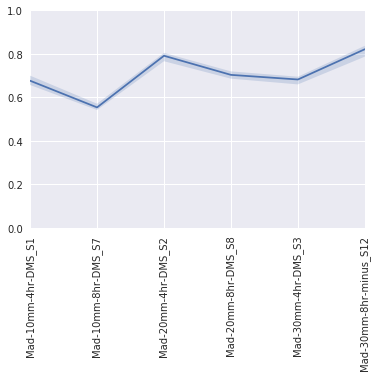

In [44]:
sns.set(font_scale=1)
ratios_readCounts_Madrasin_justDMS_matrix = ratios_readCounts_Madrasin_justDMS.values
ax = sns.tsplot(data=ratios_readCounts_Madrasin_justDMS_matrix,estimator=np.median)
#ax.set(xticklabels=)
ax.set_xticklabels(labels=avg_ratios_readCounts_Madrasin_justDMS.index.values,rotation=90)
plt.ylim(0, 1)

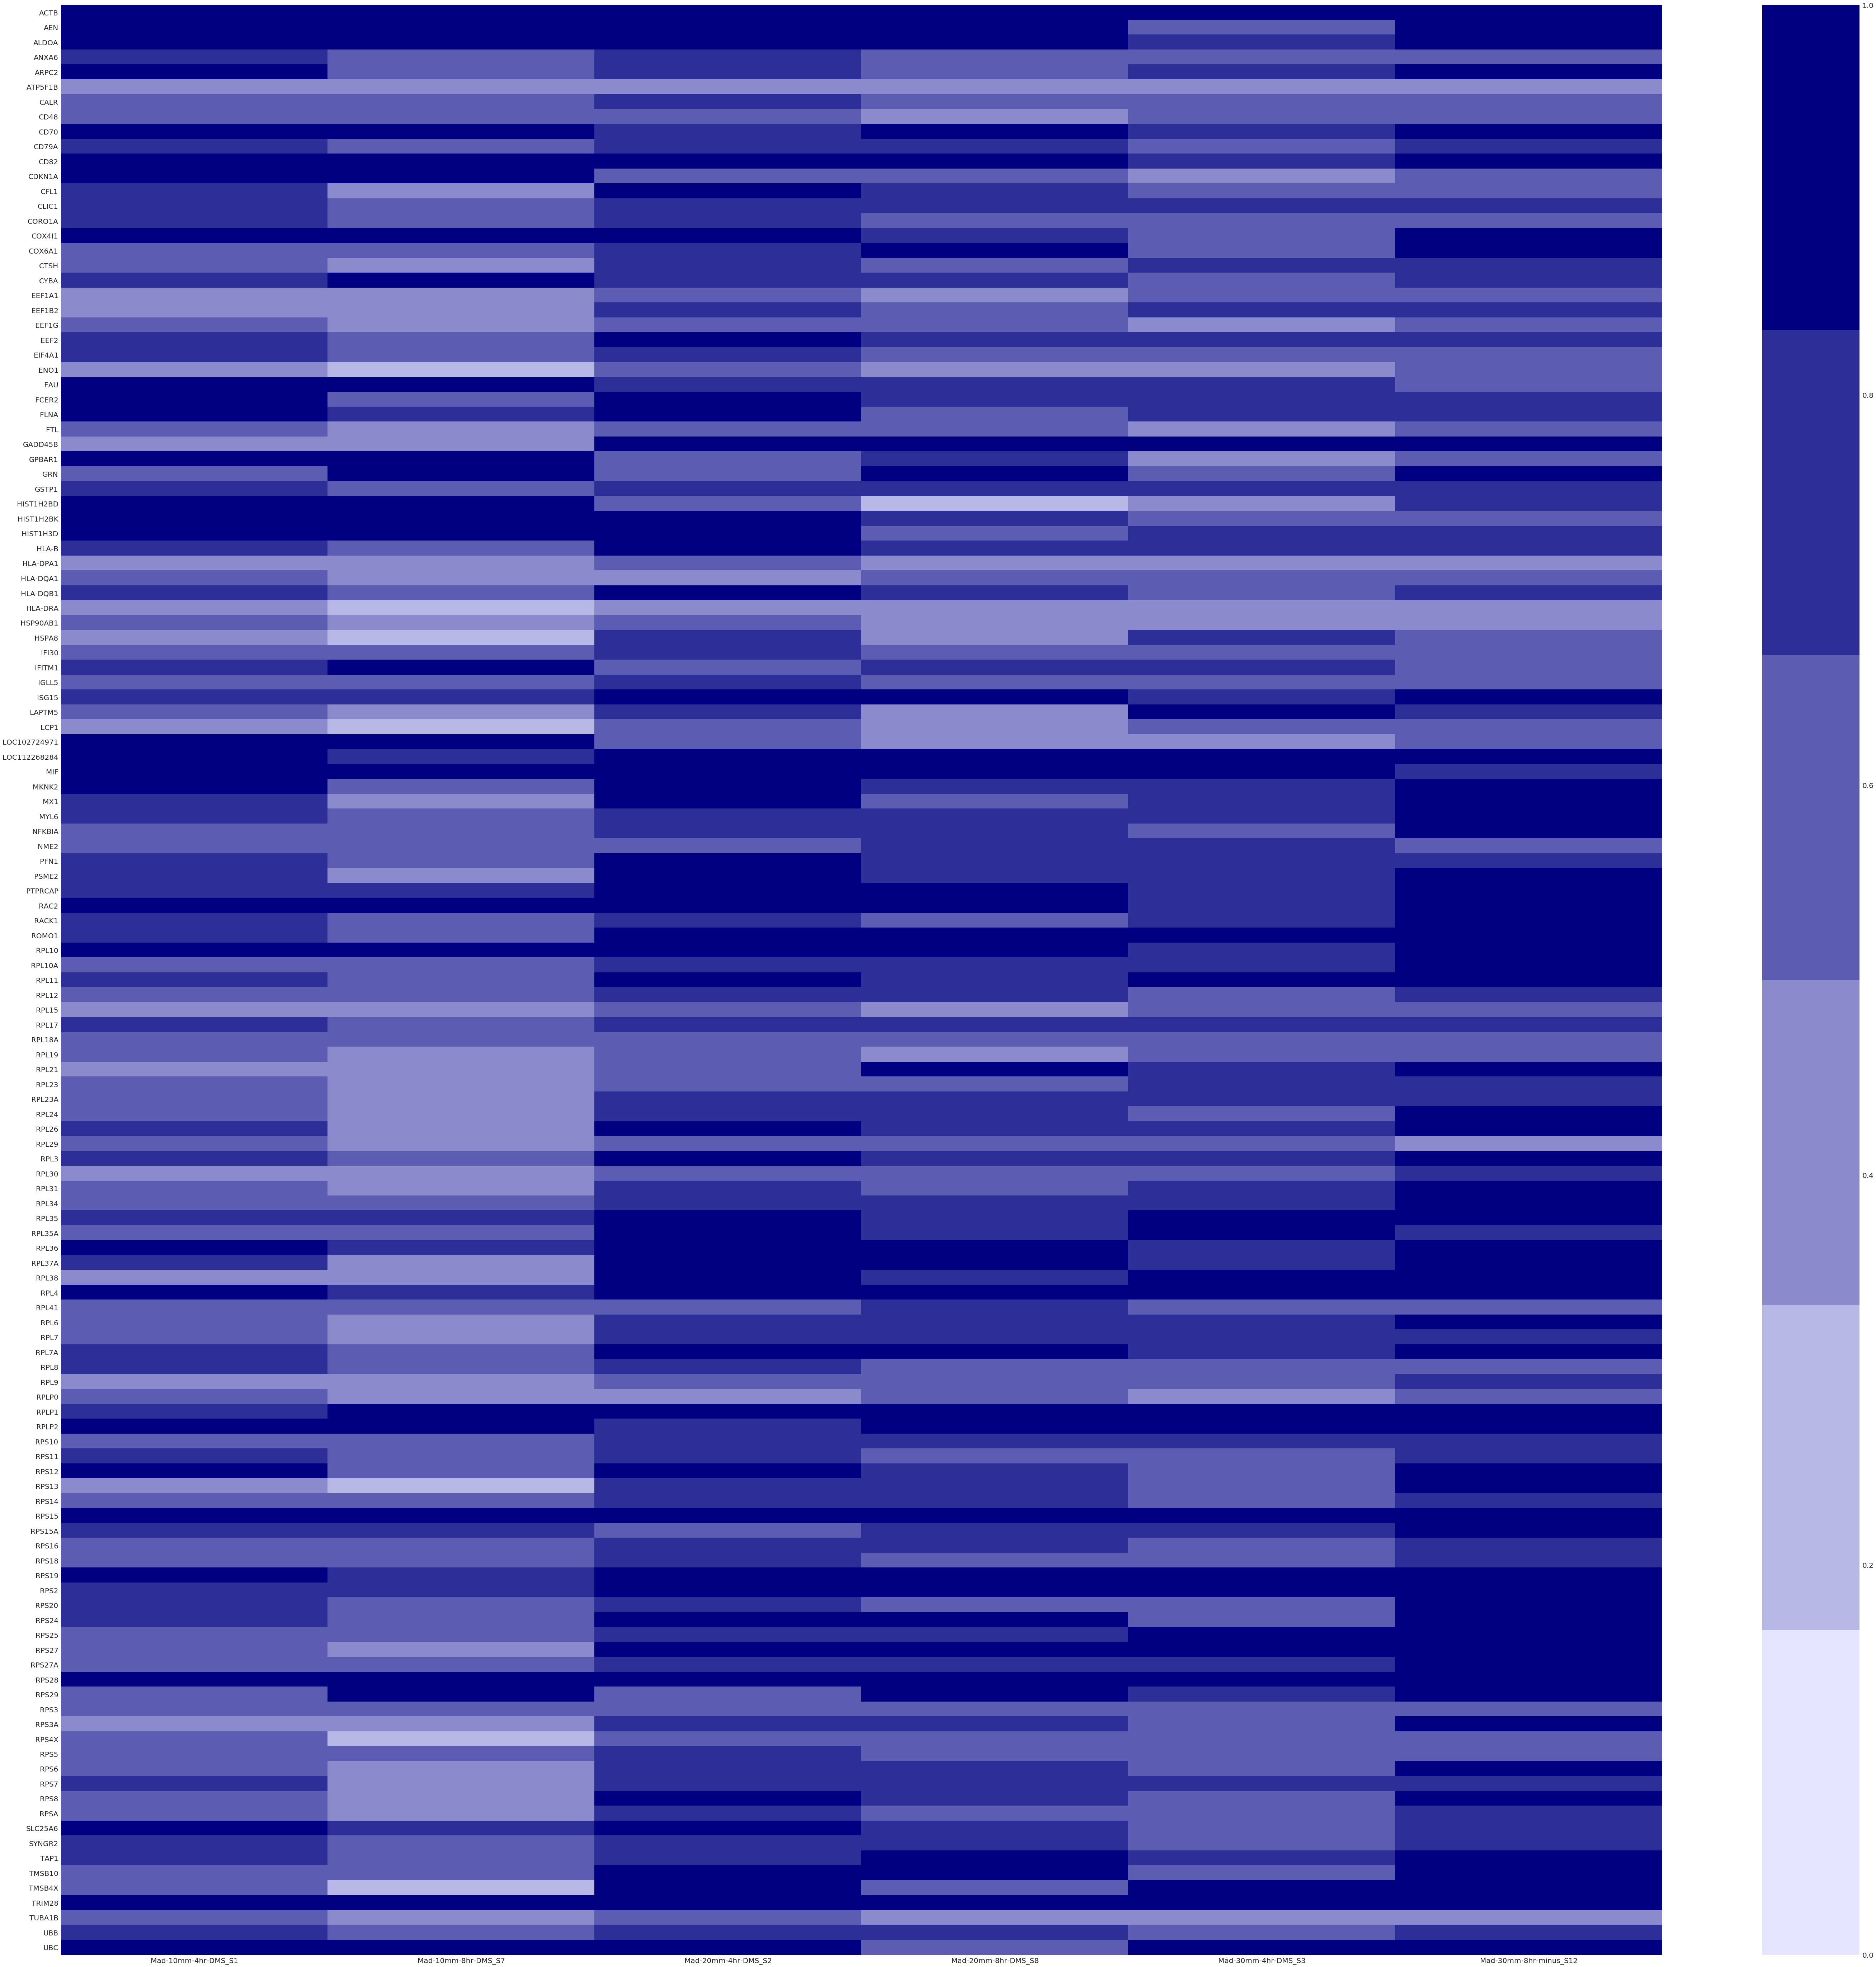

In [45]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts_Madrasin_justDMS,cmap=sns.light_palette("navy", reverse=False),vmax=1,vmin=0,yticklabels=True, ax=ax)

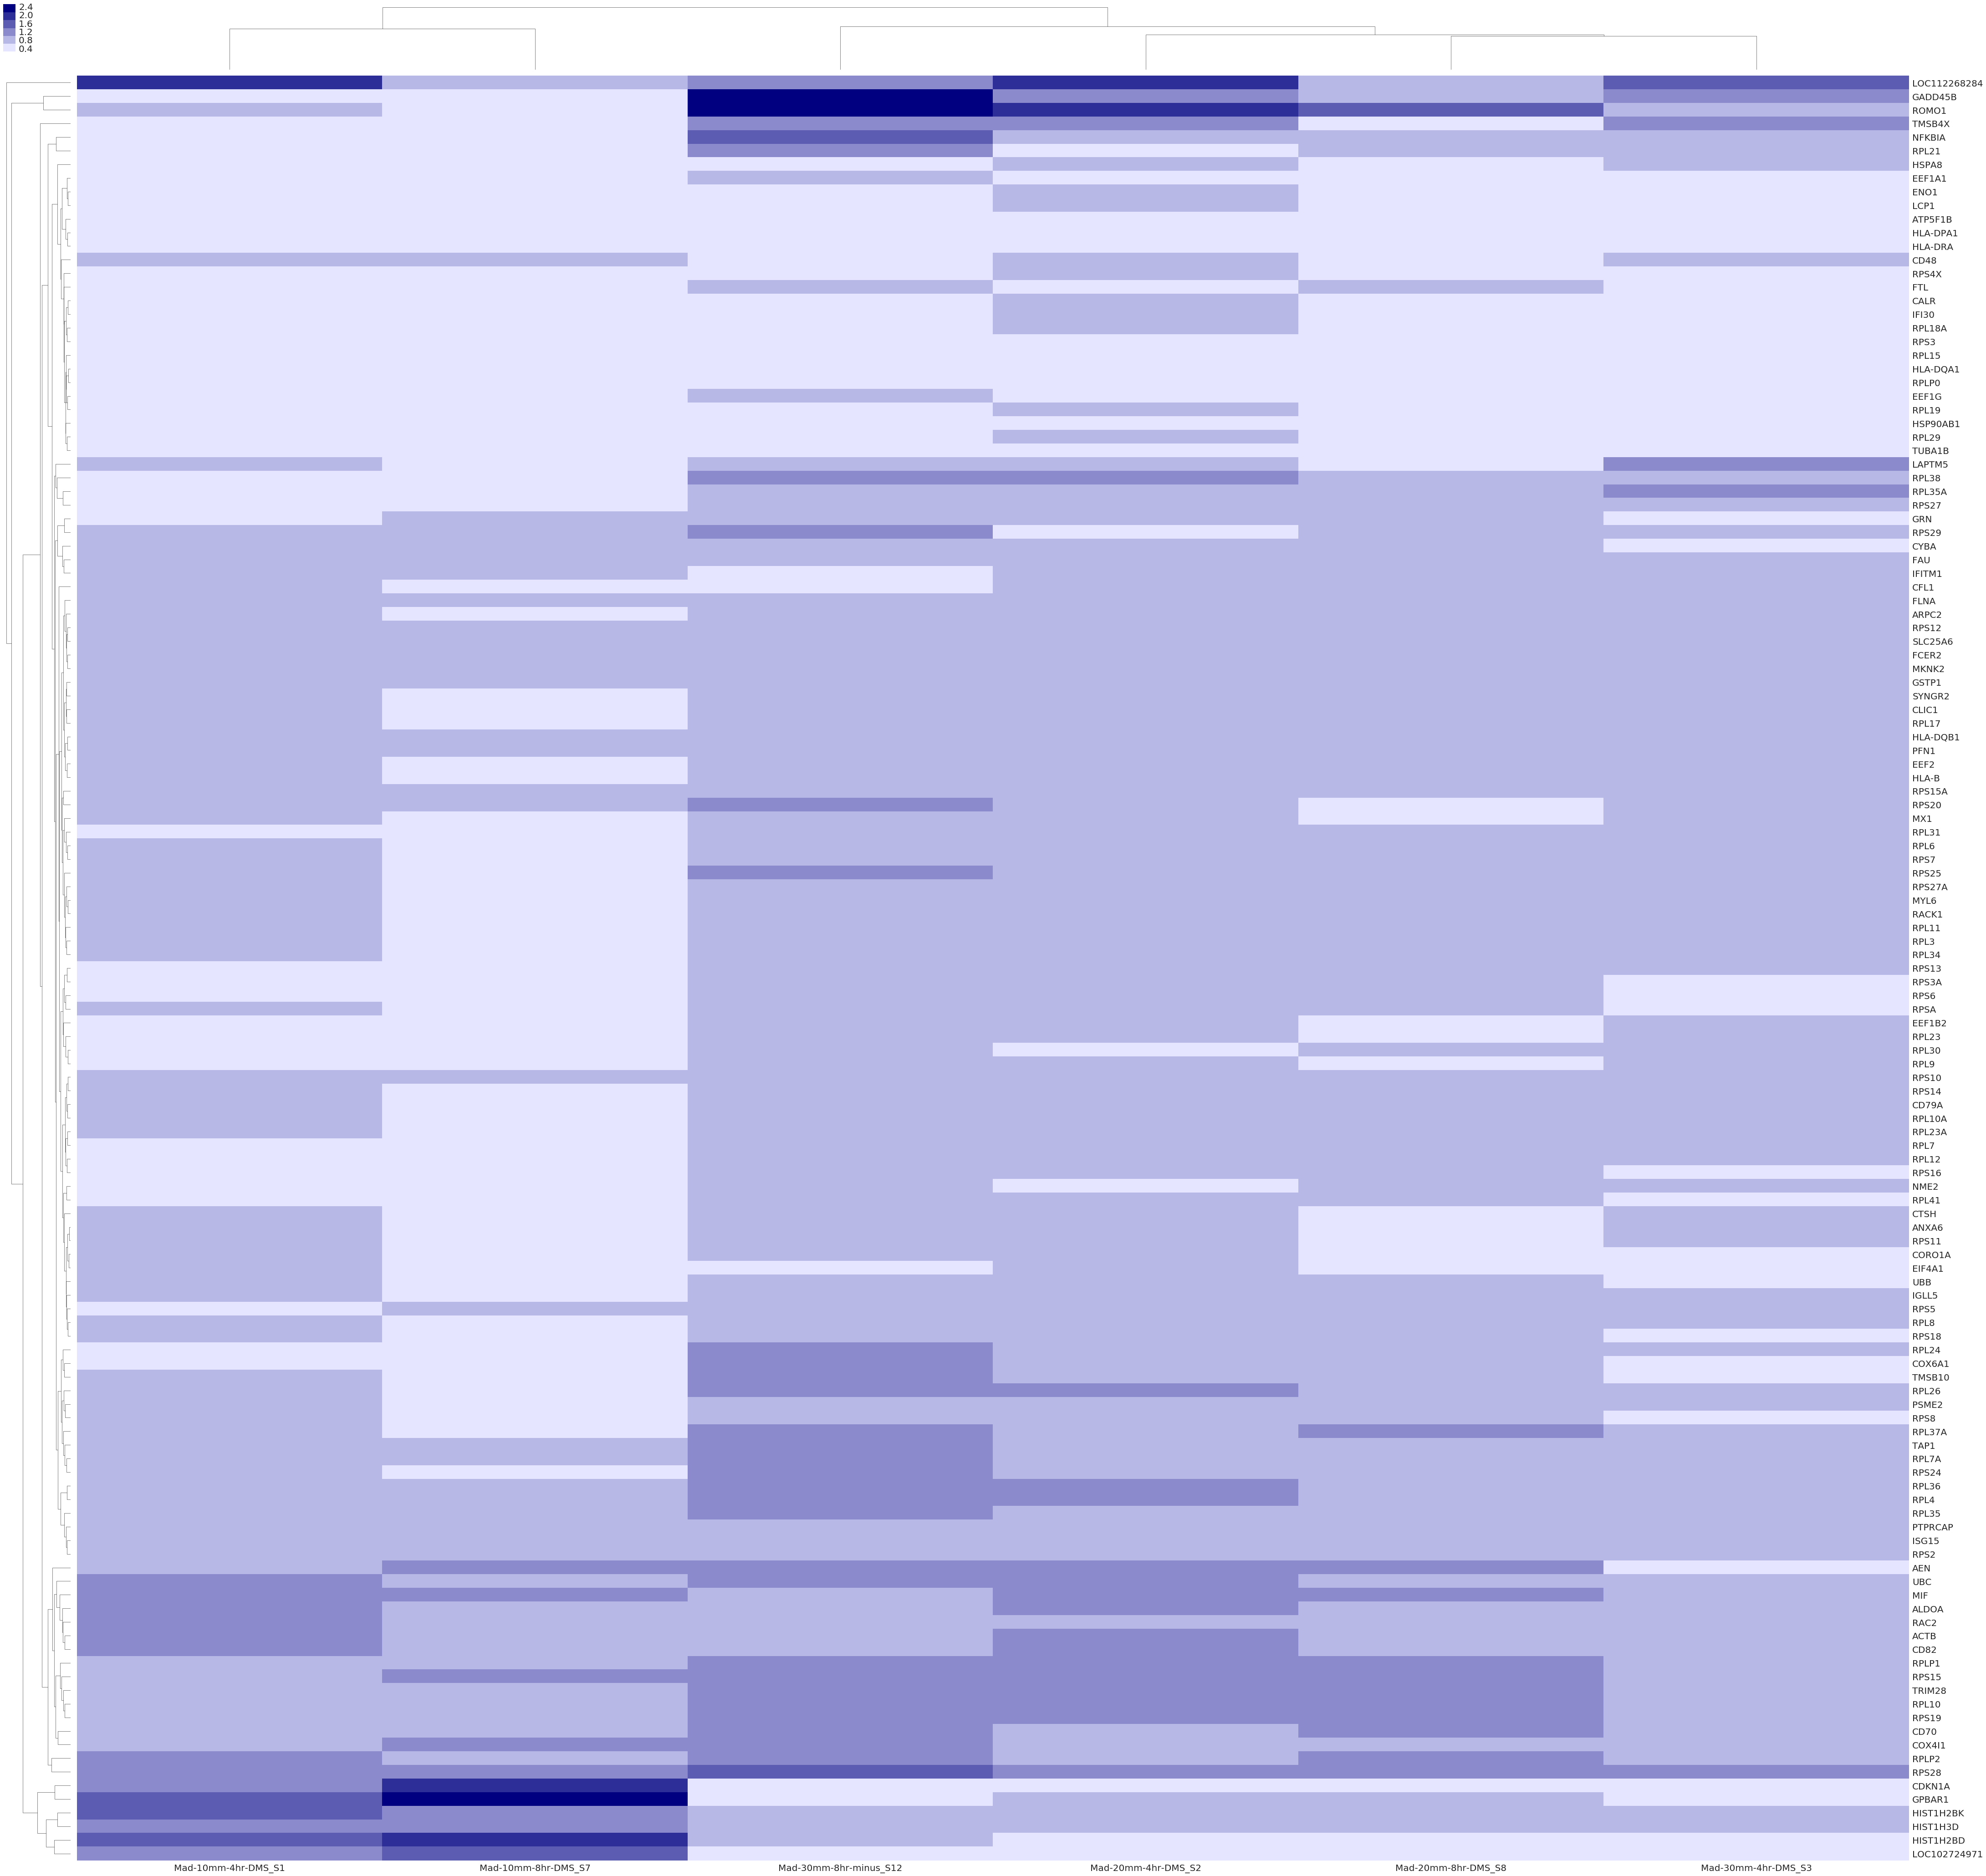

In [46]:
ax = sns.clustermap(ratios_readCounts_Madrasin_justDMS,cmap=sns.light_palette("navy", reverse=False),annot=False, square=False, yticklabels=True, figsize=(75,75))
reordered_indices = ax.dendrogram_row.reordered_ind

In [48]:
labels_indices_org = ratios_readCounts_Madrasin_justDMS.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratios_readCounts_Madrasin_justDMS= ratios_readCounts_Madrasin_justDMS.reindex(labels_indices_reordered)

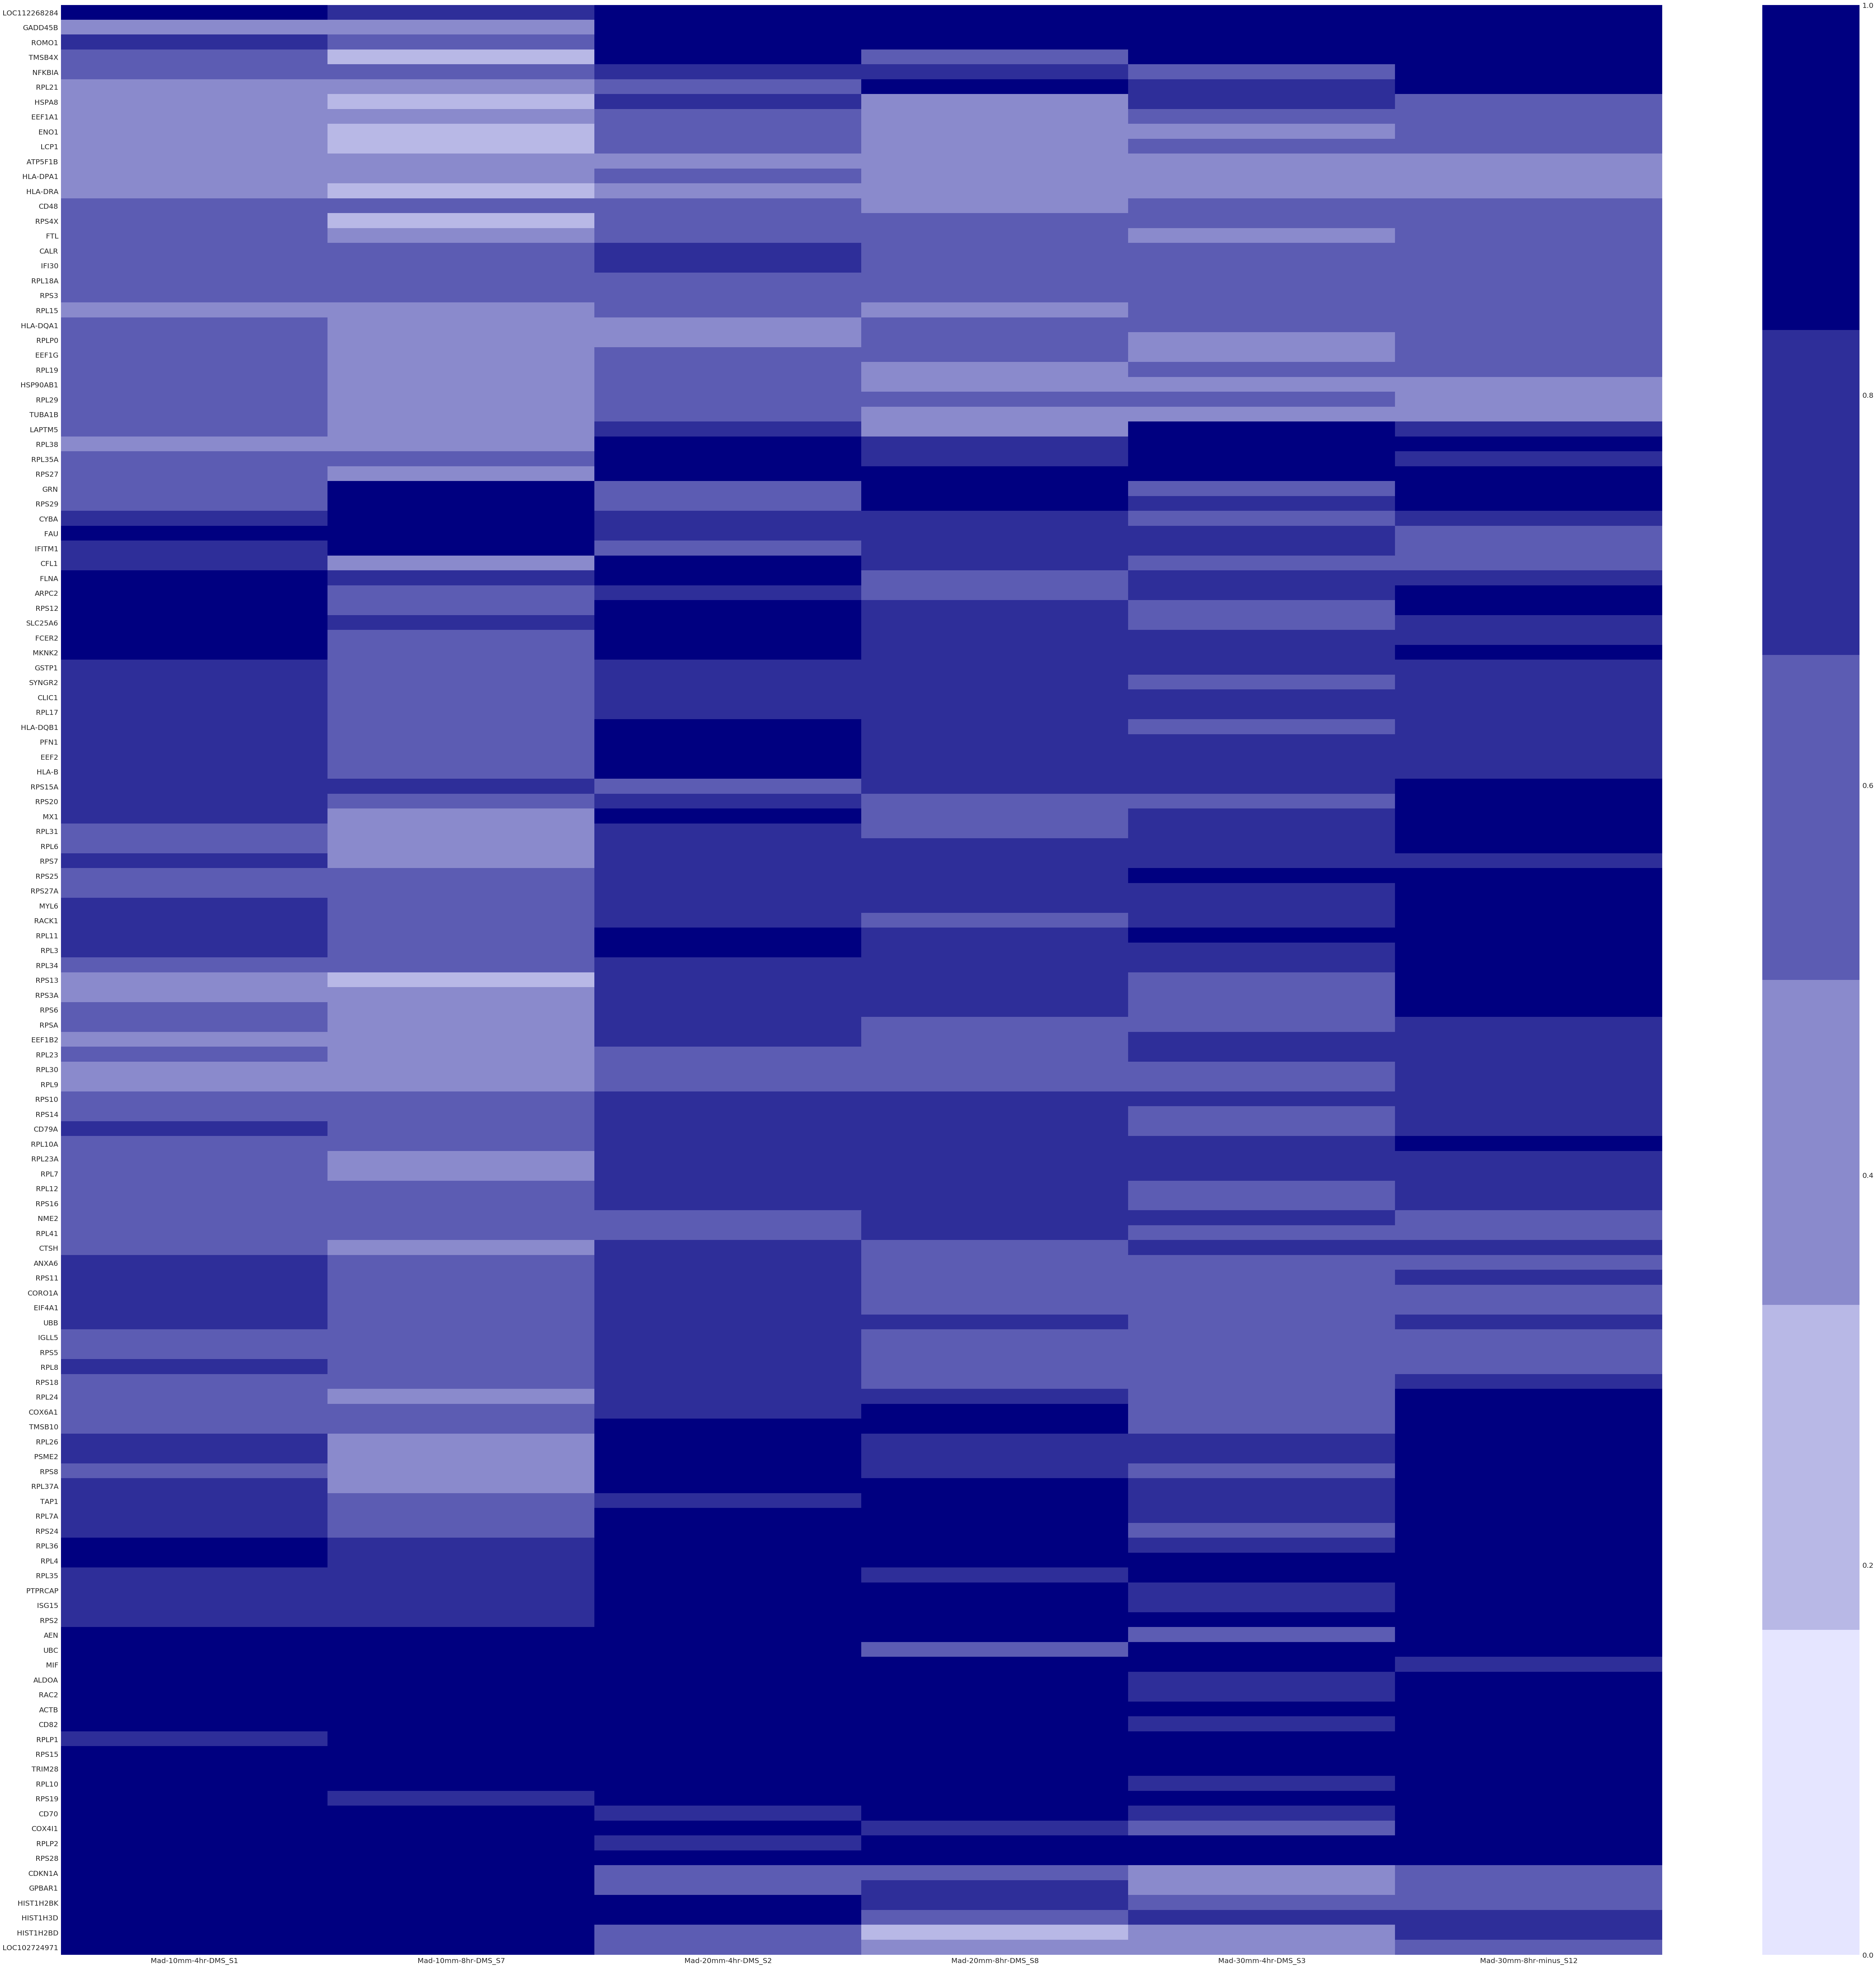

In [49]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts_Madrasin_justDMS,cmap=sns.light_palette("navy", reverse=False),vmax=1,vmin=0,yticklabels=True, ax=ax)

In [52]:
# Get ratios for just nonDMS data
columns_nonDMS = [i for i in feature_readCounts_Madrasin.columns.values if ("minus" in i and "Mad-30mm-8hr-minus" not in i) or ("Mad-30mm-8hr-DMS" in i)  ]
columns_nonDMS = sorted(columns_nonDMS)
columns_nonDMS

['Mad-10mm-4hr-minus_S4',
 'Mad-10mm-8hr-minus_S10',
 'Mad-20mm-4hr-minus_S5',
 'Mad-20mm-8hr-minus_S11',
 'Mad-30mm-4hr-minus_S6',
 'Mad-30mm-8hr-DMS_S9']

In [55]:
feature_readCounts_Madrasin_minus = feature_readCounts_Madrasin[columns_nonDMS]
feature_readCounts_Madrasin_minus.head()

,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,2046.890,1959.640,2530.640,1924.070,2264.1900,1787.0600
AEN,170.150,133.278,100.843,272.079,83.4827,72.7791
ALDOA,178.638,233.420,255.007,248.159,230.4310,178.2020
ANXA6,334.148,300.044,300.164,309.576,353.8490,334.9680
ARPC2,313.504,300.337,348.396,335.065,383.5550,302.5820


In [56]:
ratios_readCounts_Madrasin_minus = feature_readCounts_Madrasin_minus.divide(feature_readCounts_Control["All_Minusfiles"],axis=0)
ratios_readCounts_Madrasin_minus.head()

,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,1.030509,0.986583,1.274054,0.968675,1.139909,0.899697
AEN,1.197826,0.938254,0.709917,1.915388,0.587704,0.512352
ALDOA,0.847280,1.107111,1.209498,1.177018,1.092934,0.845212
ANXA6,1.199865,1.077404,1.077835,1.111631,1.270608,1.202809
ARPC2,1.063724,1.019048,1.182113,1.136881,1.301408,1.026666


In [57]:
# Lets the average for every time point and concentration
avg_ratios_readCounts_Madrasin_minus = ratios_readCounts_Madrasin_minus.apply(np.mean,axis=0)
avg_ratios_readCounts_Madrasin_minus

Mad-10mm-4hr-minus_S4     1.072077
Mad-10mm-8hr-minus_S10    1.079189
Mad-20mm-4hr-minus_S5     1.133769
Mad-20mm-8hr-minus_S11    1.128024
Mad-30mm-4hr-minus_S6     1.180127
Mad-30mm-8hr-DMS_S9       1.120852
dtype: float64

(0, 1.5)

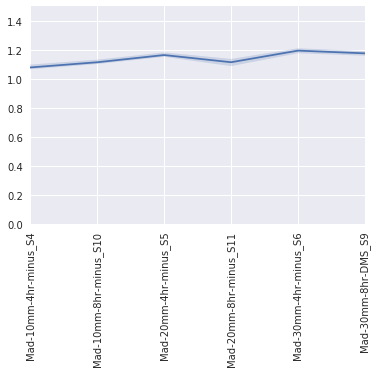

In [60]:
sns.set(font_scale=1)
ratios_readCounts_Madrasin_minus_matrix = ratios_readCounts_Madrasin_minus.values
ax = sns.tsplot(data=ratios_readCounts_Madrasin_minus_matrix,estimator=np.median)
#ax.set(xticklabels=)
ax.set_xticklabels(labels=avg_ratios_readCounts_Madrasin_minus.index.values,rotation=90)
plt.ylim(0, 1.5)

In [70]:
min(ratios_readCounts_Madrasin_minus_matrix.flatten())

0.1226309318908286

In [71]:
max(ratios_readCounts_Madrasin_minus_matrix.flatten())

2.5948628087626018

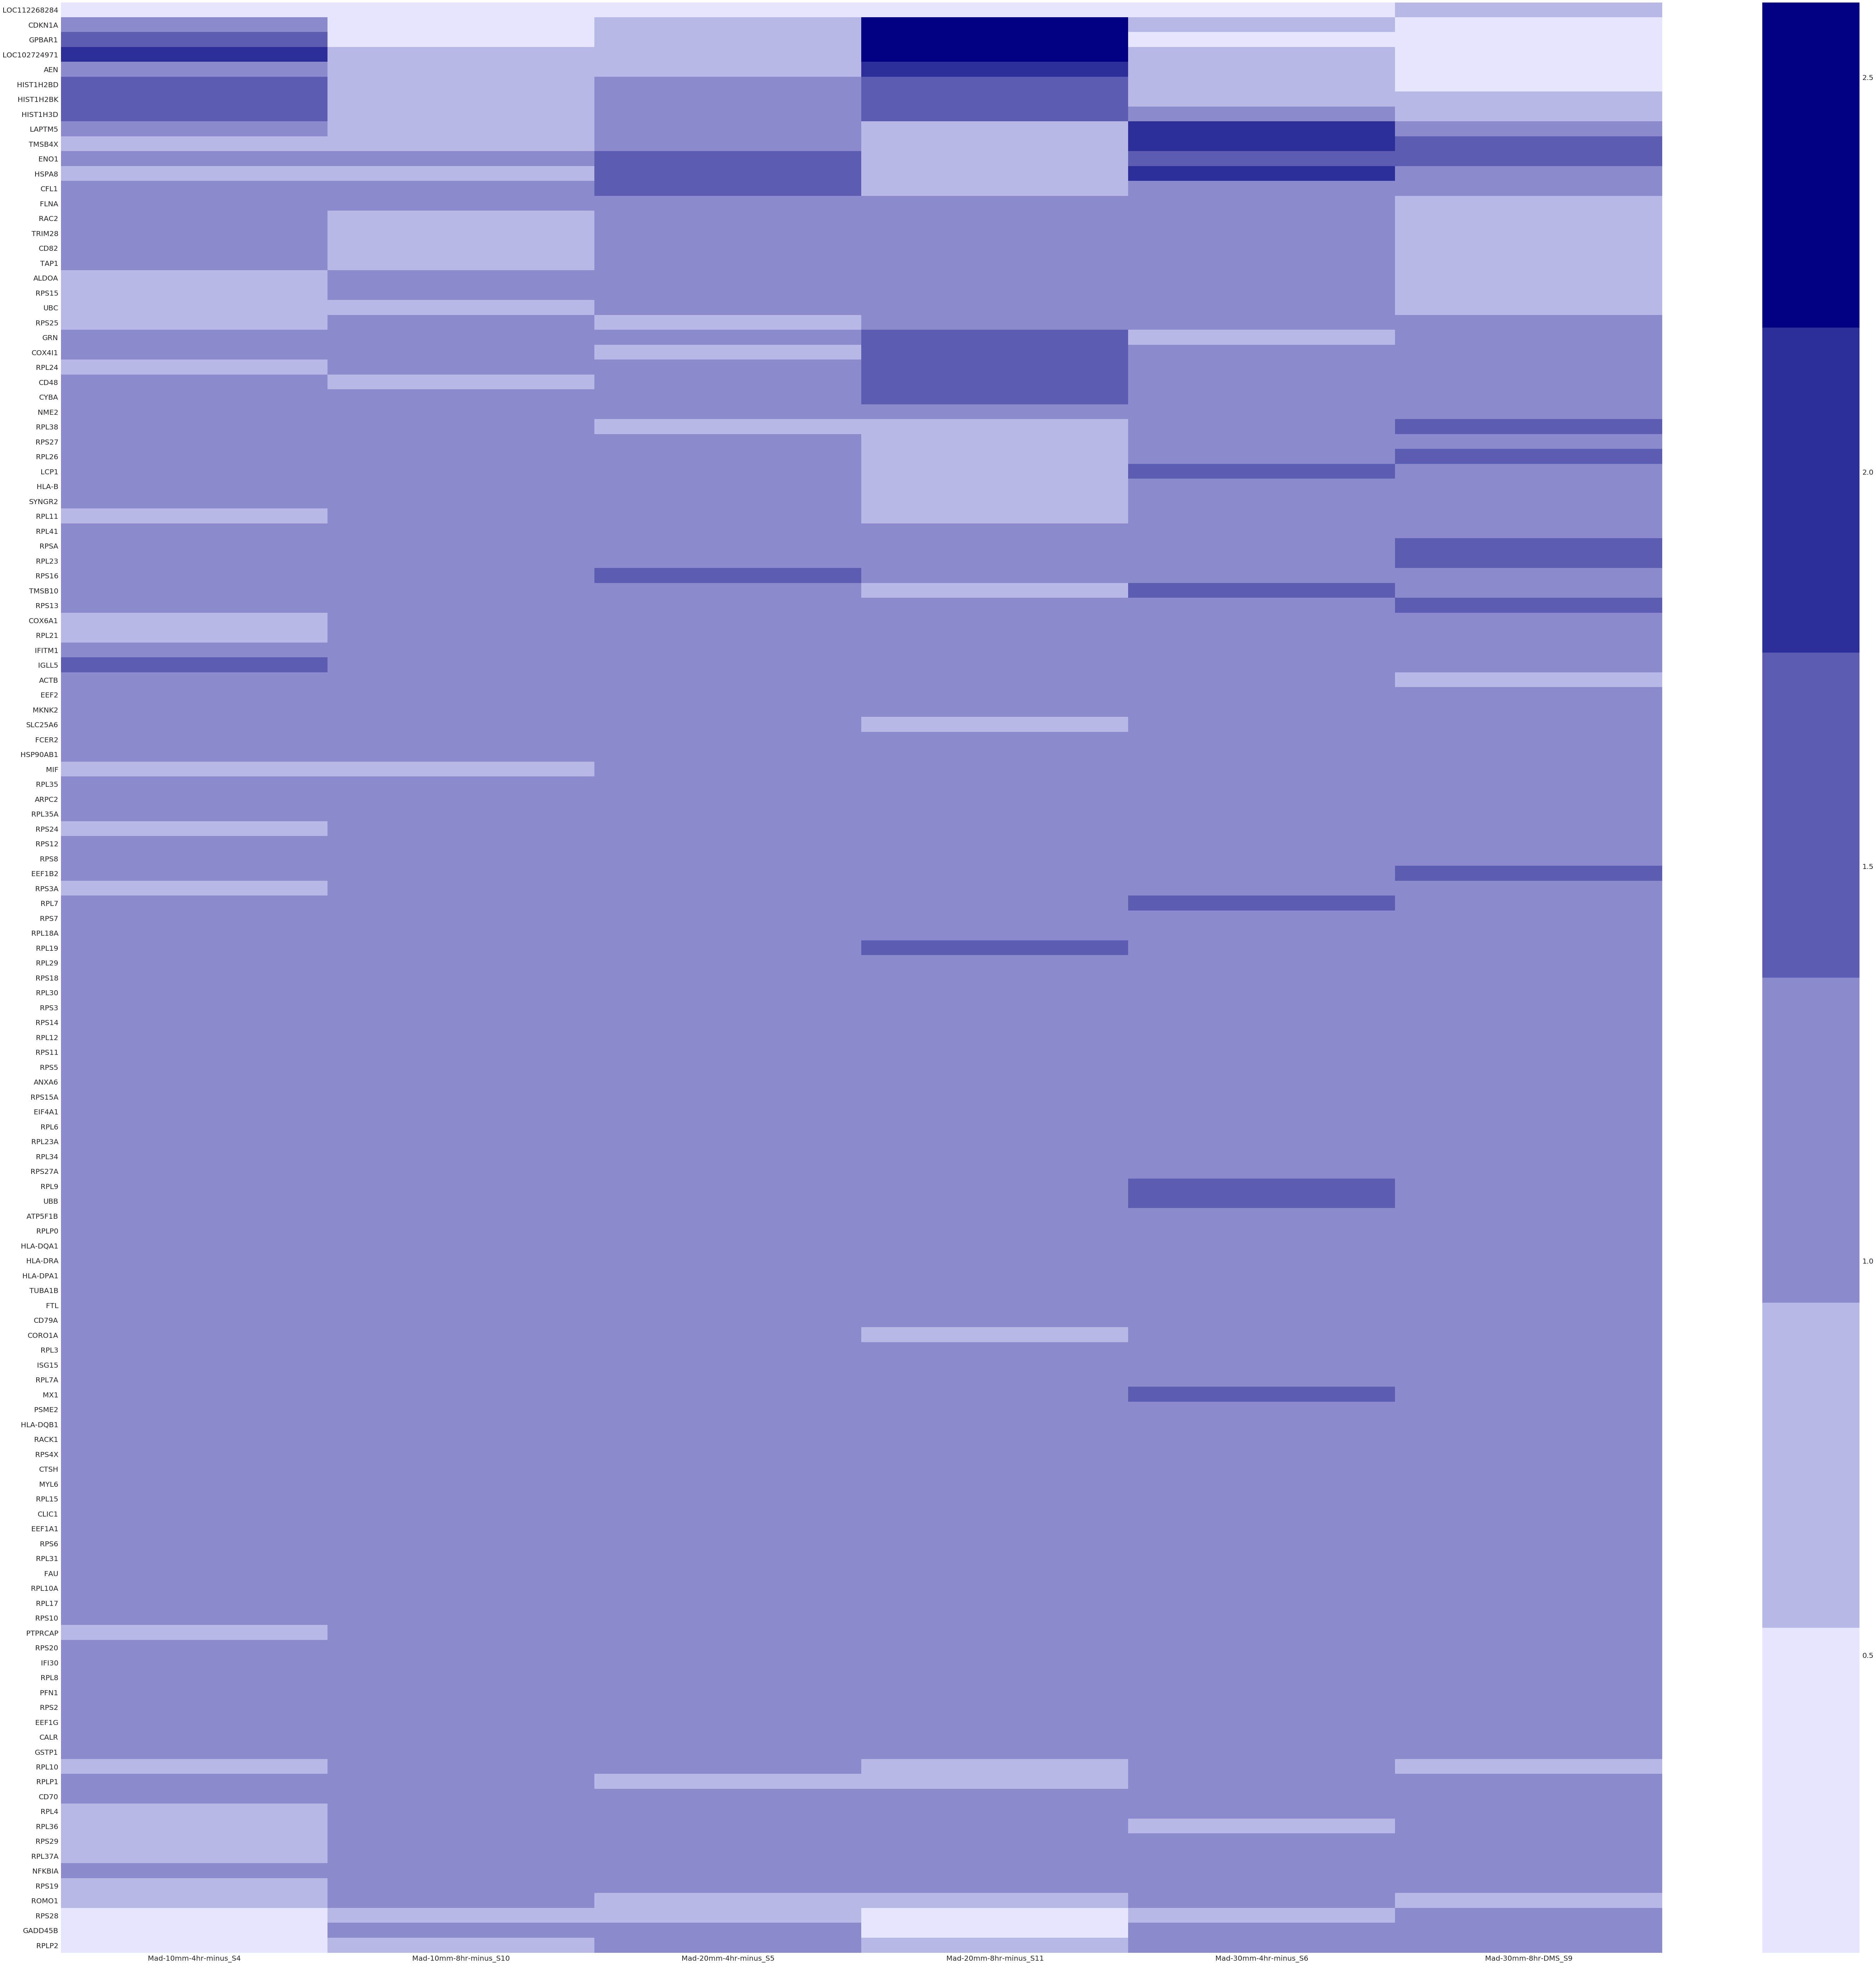

In [72]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts_Madrasin_minus,cmap=sns.light_palette("navy", reverse=False),vmin=min(ratios_readCounts_Madrasin_minus_matrix.flatten()),vmax=max(ratios_readCounts_Madrasin_minus_matrix.flatten()),yticklabels=True, ax=ax)

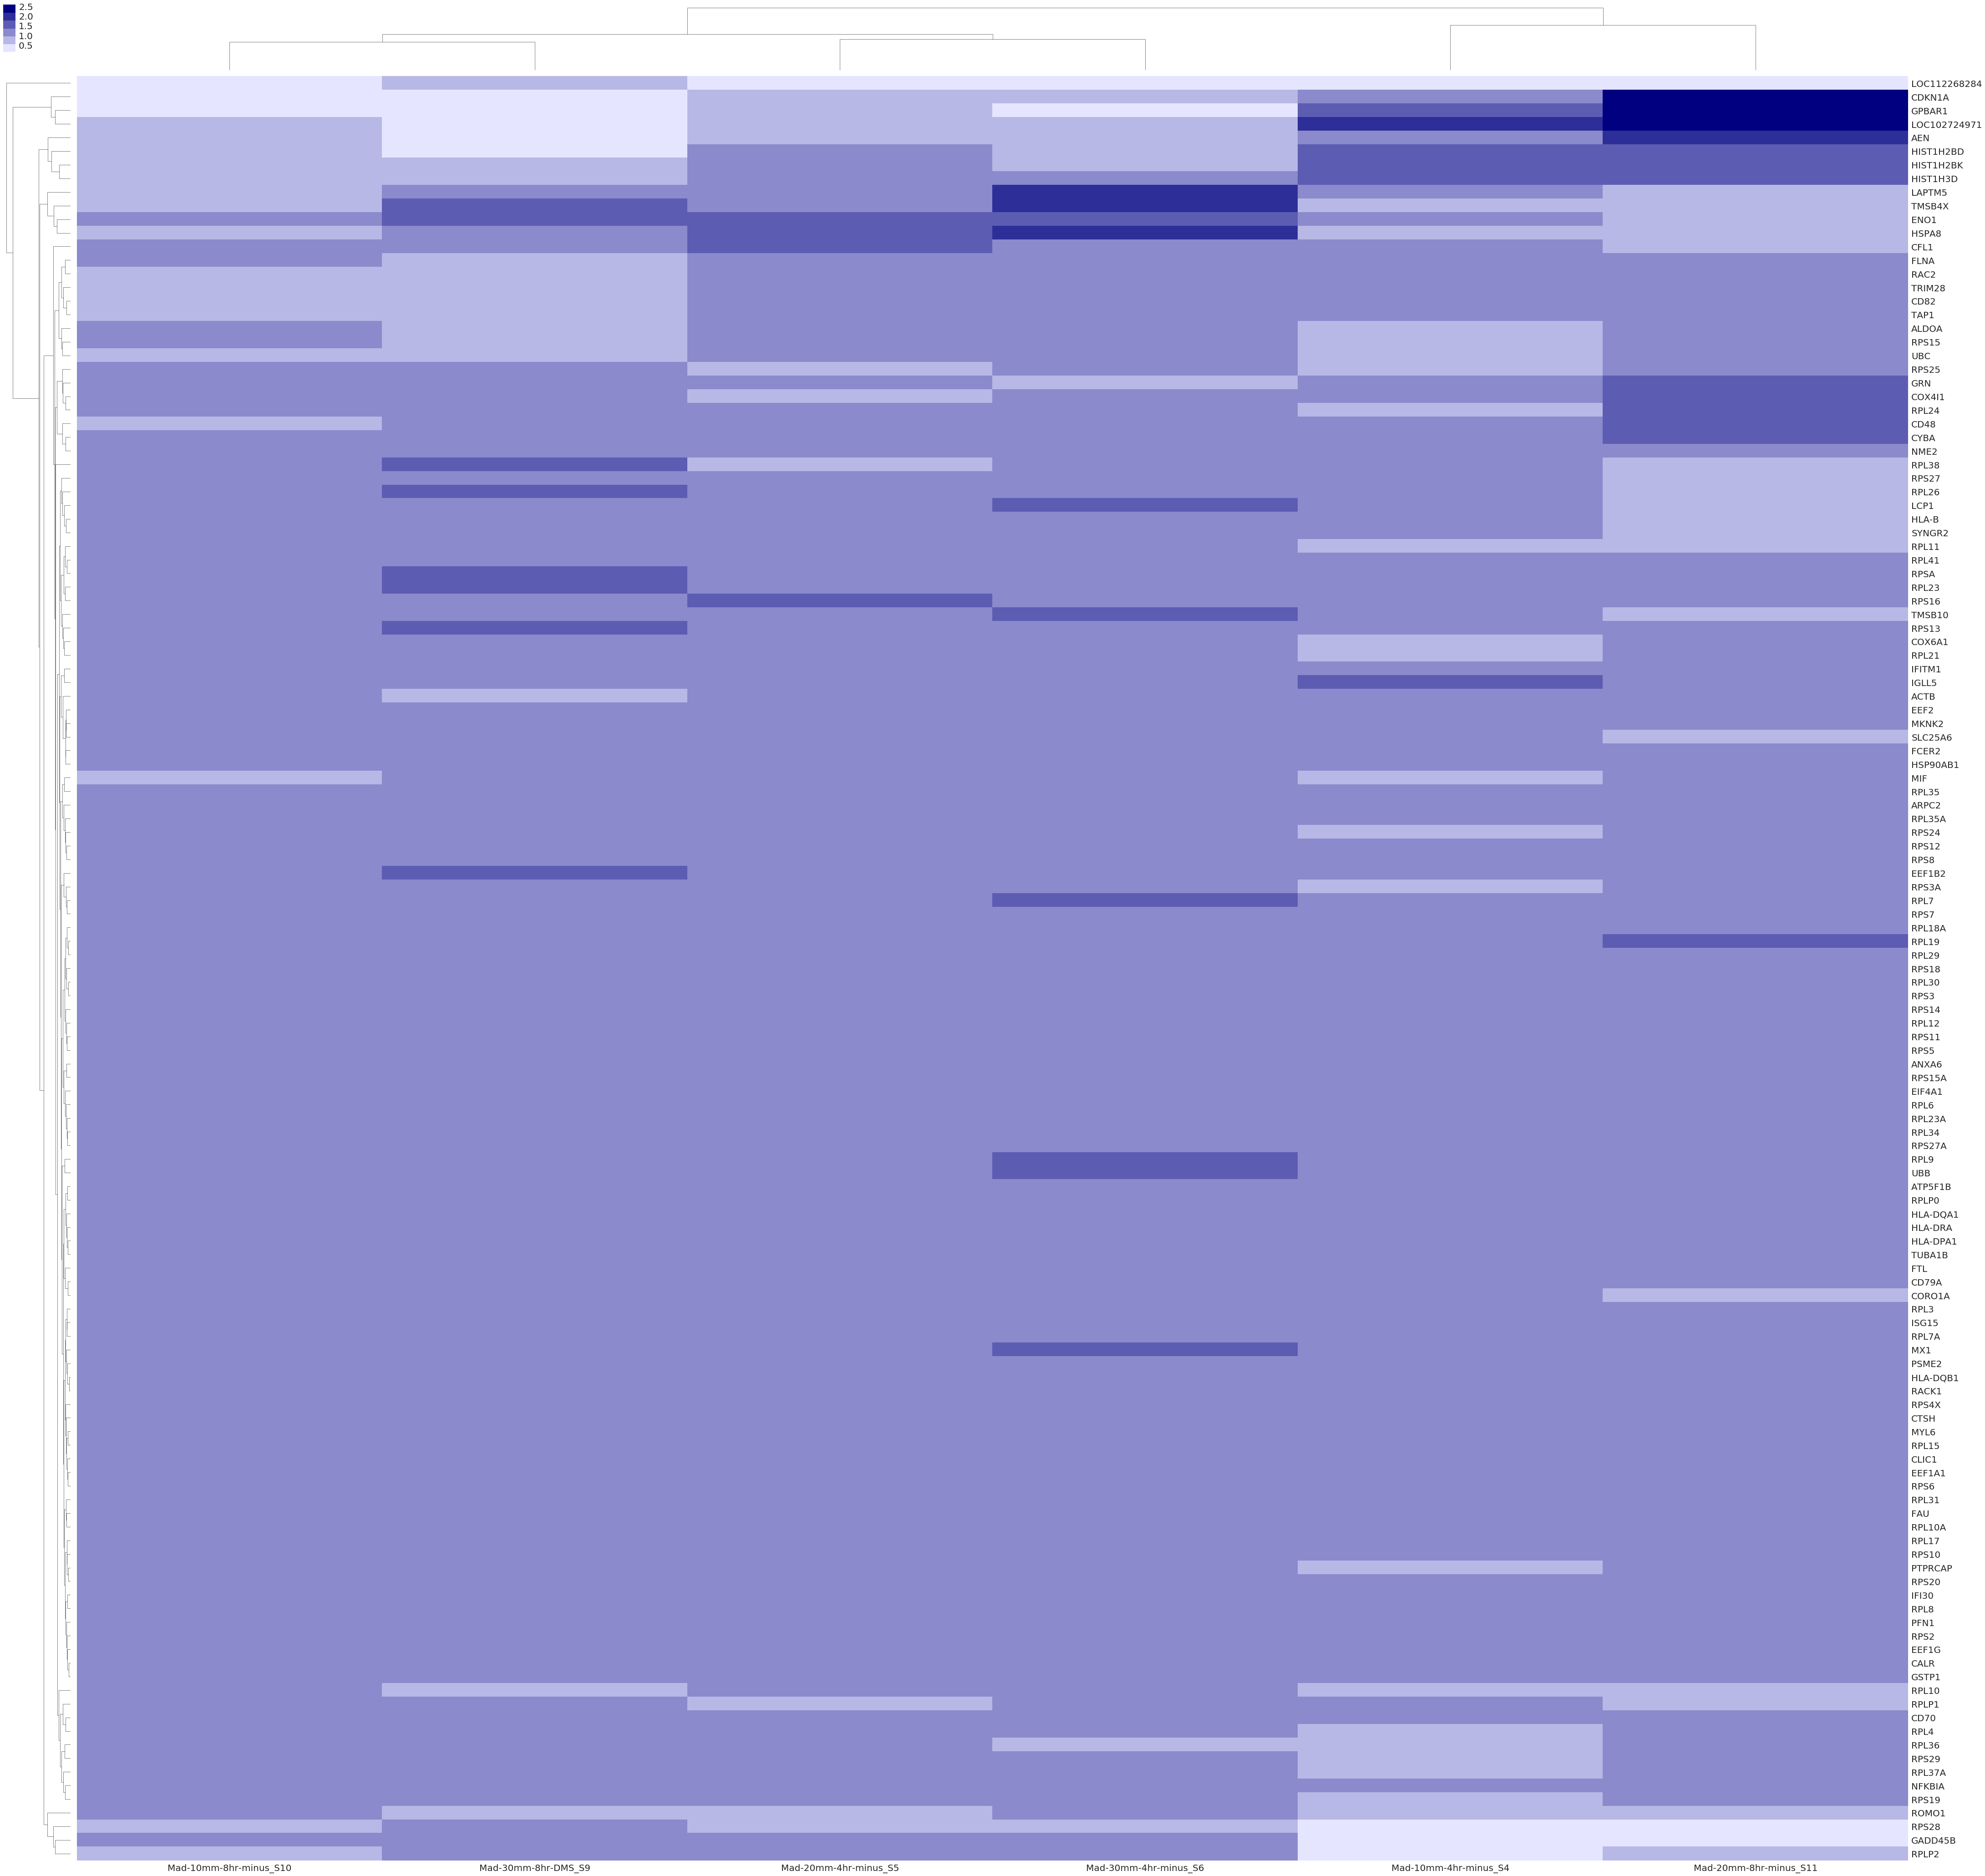

In [73]:
ax = sns.clustermap(ratios_readCounts_Madrasin_minus,cmap=sns.light_palette("navy", reverse=False),annot=False, square=False, yticklabels=True, figsize=(75,75))
reordered_indices = ax.dendrogram_row.reordered_ind

In [74]:
labels_indices_org = ratios_readCounts_Madrasin_minus.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratios_readCounts_Madrasin_minus= ratios_readCounts_Madrasin_minus.reindex(labels_indices_reordered)

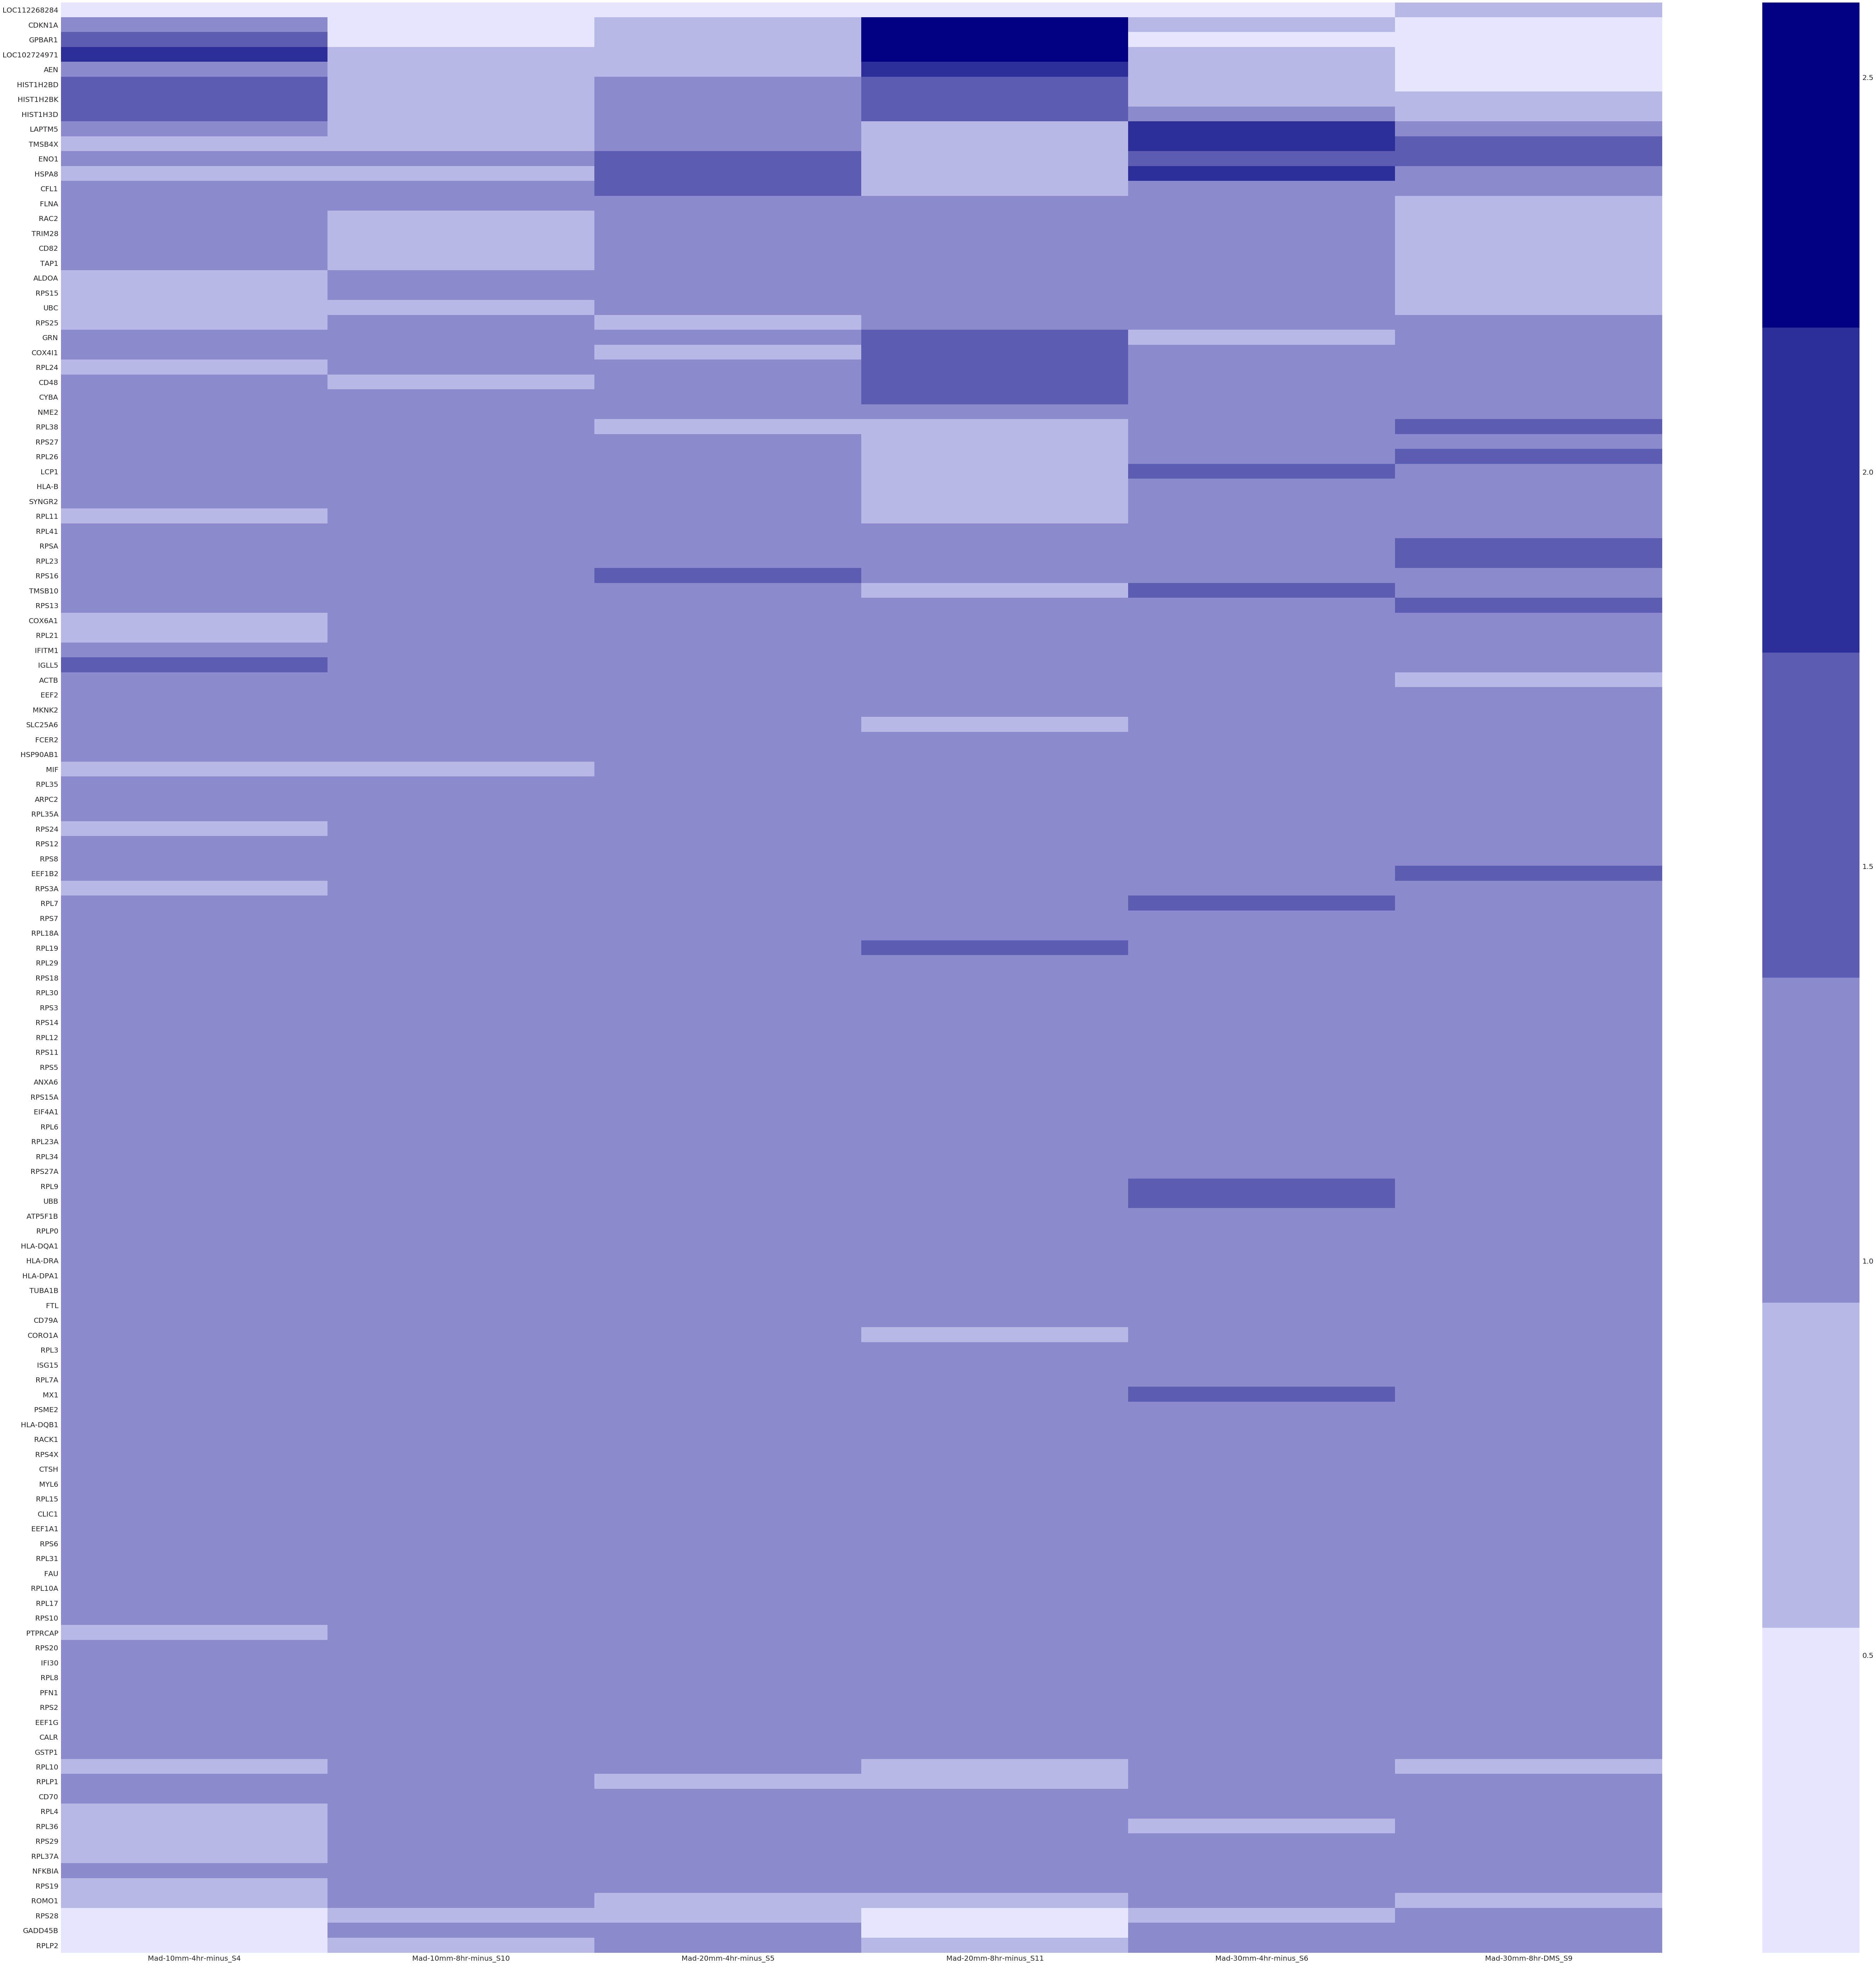

In [75]:
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts_Madrasin_minus,cmap=sns.light_palette("navy", reverse=False),vmin=min(ratios_readCounts_Madrasin_minus_matrix.flatten()),vmax=max(ratios_readCounts_Madrasin_minus_matrix.flatten()),yticklabels=True, ax=ax)